# Cosmic Pi Data Analysis examples
This is a Jupyter Notebook, written in Python.
It runs on a remote server. 
You can fully control the analysis from your web browser.
We're only going to scratch the surface of the data today, but let's get started!

In [1]:
#let's check this thing works!
print("hello world")

hello world


If you can see the text "hello world" printed out above, then your system is working! Now let's check which version of the Python interpreter you are using.
Some older software uses Python 2, but we should be using Python 3 for this example.

In [2]:
#check our python version, it should be 3.10.10
from platform import python_version
print(python_version())

3.10.10


If it says 3.10.10 above, you are running the right version!
Now we can connect to the database which holds all the Cosmic Pi data from our server.
First we load the library which has all the connection commands:

In [3]:
#load the database communication module
from influxdb import InfluxDBClient

And now we can open a connection. This is like opening a webpage, but we can ask it to provide us with information from the database by asking a question (query).

In [4]:
#connect to the database of events
client = InfluxDBClient(host='localhost', port=8086, database='cosmicpiglobal')


To process our data, we will need some additional libraries. First we load them (import) and then we can use the functions they contain.

In [5]:
#load the datetime module and import functionality from the host OS
from datetime import datetime
import os
import argparse
import json
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /tmp/matplotlib-1zvjv3zg because the default path (/home/jupyter-jupyter/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Let's get started asking some questions! First, we can ask a simple one about how many detectors we have registered in the database.
We ask for the 'tag' values, which are the detector ID's, from the CosmicPiV1.8.1 measurement table.
We tell the database to return them in ascending order, with a maximum of 100 detectors.

In [6]:
query = 'show tag values from \"CosmicPiV1.8.1\" with key=\"id\" ORDER BY ASC LIMIT 100'

In [7]:
print("Querying data: " + query)
result = client.query(query)
print("Result: {0}".format(result))

Querying data: show tag values from "CosmicPiV1.8.1" with key="id" ORDER BY ASC LIMIT 100
Result: ResultSet({'('CosmicPiV1.8.1', None)': [{'key': 'id', 'value': '202481587201533'}, {'key': 'id', 'value': '202481593594661'}, {'key': 'id', 'value': '202481594491678'}, {'key': 'id', 'value': '202481596047885'}]})


The text above should say:
Querying data: show tag values from "CosmicPiV1.8.1" with key="id" ORDER BY ASC LIMIT 100
Result: ResultSet({'('CosmicPiV1.8.1', None)': [{'key': 'id', 'value': '202481587201533'}, {'key': 'id', 'value': '202481593594661'}, {'key': 'id', 'value': '202481594491678'}, {'key': 'id', 'value': '202481596047885'}]})

This means that we have 4 detectors! But only 2 made the journey to the North Pole.. what is going on?
We give each detector a unique number, so we can tell which is which. However, the unique number actually comes from one of the circuit boards inside the detector. If we change that circuit board, we will end up with a different serial number.
In fact, only 2 detectors went to the North Pole, but they both needed maintenance en-route and had to have the circuit board changed that gives them their ID. 
This is an illustration of 2 things:
1) Data analysis can be complicated by lots of inconvenient real world things!
2) We cannot do data analysis in a vacuum, we also need to know about what we are analysing!

Now let's ask a more interesting question...

In [8]:
query_lat = "SELECT \"lat\" FROM \"CosmicPiV1.8.1\" WHERE (\"id\"::tag = '202481593594661') ORDER BY DESC LIMIT 1"
query_lon = "SELECT \"lon\" FROM \"CosmicPiV1.8.1\" WHERE (\"id\"::tag = '202481593594661') ORDER BY DESC LIMIT 1"

The Nansen detector, now in the Fram museum, had the ID number of 202481593594661 when it was at the North Pole. 
We will ask the database what the last location of this device was!

In [9]:
print("Querying data: " + query_lat + query_lon)
result_lat = client.query(query_lat)
result_lon = client.query(query_lon)
print("Result: {0}".format(result_lat))
print("Result: {0}".format(result_lon))

Querying data: SELECT "lat" FROM "CosmicPiV1.8.1" WHERE ("id"::tag = '202481593594661') ORDER BY DESC LIMIT 1SELECT "lon" FROM "CosmicPiV1.8.1" WHERE ("id"::tag = '202481593594661') ORDER BY DESC LIMIT 1
Result: ResultSet({'('CosmicPiV1.8.1', None)': [{'time': '2024-06-26T12:42:10.556014Z', 'lat': 44.19553833333333}]})
Result: ResultSet({'('CosmicPiV1.8.1', None)': [{'time': '2024-06-26T12:42:10.556014Z', 'lon': 15.145713333333333}]})


Is the Nansen detector still at the North Pole? No... so how can we find data from when it was there?

In [10]:
query_lat = "SELECT \"lat\" FROM \"CosmicPiV1.8.1\" WHERE (\"id\"::tag = '202481593594661') ORDER BY ASC LIMIT 1"
query_lon = "SELECT \"lon\" FROM \"CosmicPiV1.8.1\" WHERE (\"id\"::tag = '202481593594661') ORDER BY ASC LIMIT 1"

In [11]:
print("Querying data: " + query_lat + query_lon)
result_lat = client.query(query_lat)
result_lon = client.query(query_lon)
print("Result: {0}".format(result_lat))
print("Result: {0}".format(result_lon))

Querying data: SELECT "lat" FROM "CosmicPiV1.8.1" WHERE ("id"::tag = '202481593594661') ORDER BY ASC LIMIT 1SELECT "lon" FROM "CosmicPiV1.8.1" WHERE ("id"::tag = '202481593594661') ORDER BY ASC LIMIT 1
Result: ResultSet({'('CosmicPiV1.8.1', None)': [{'time': '1970-01-01T00:00:00.000139Z', 'lat': 0.0}]})
Result: ResultSet({'('CosmicPiV1.8.1', None)': [{'time': '1970-01-01T00:00:00.000139Z', 'lon': 0.0}]})


We've found it! But... wait a minute, there's something funny about the date. It says 1st January 1970. That can't be right?
Indeed, we are in the right place, but the wrong time! Did we invent a time machine? 
**Sadly not,** it's just that the computer clock wasn't yet set when this data came out of the detector!
When the detector turns on for the first time, it takes a while to set the clock by reading the time via GPS satellites. 
So we need to know *a lot* about our detector in order to do a proper analysis.
We also need to throw away any data which might have mistakes in it. Even in a professionally built detector, this happens.
We can check what the earliest time our system can do is with the command below:

In [12]:
datetime.fromtimestamp(0)

datetime.datetime(1970, 1, 1, 1, 0)

It's January 1970! But the expedition didn't leave New York until January 2024. So I'm afraid these data points need to go in the bin, even if they are in the right place.
Let's try to find some useful data we can work with...
We can ask the database what the frequency of Cosmic Rays detected was. The detector reports this every second, we will ask for the last ten minutes (600 seconds).

In [13]:
query_evt = "SELECT \"event_count\" FROM \"CosmicPiV1.8.1_freq\"  ORDER BY DESC LIMIT 600"
result_evt = client.query(query_evt)
print("Result: {0}".format(result_evt))

Result: ResultSet({'('CosmicPiV1.8.1_freq', None)': [{'time': '2024-06-26T12:42:11Z', 'event_count': 2.0}, {'time': '2024-06-26T12:42:10Z', 'event_count': 4.0}, {'time': '2024-06-26T12:42:09Z', 'event_count': 2.0}, {'time': '2024-06-26T12:42:08Z', 'event_count': 4.0}, {'time': '2024-06-26T12:42:07Z', 'event_count': 2.0}, {'time': '2024-06-26T12:42:06Z', 'event_count': 4.0}, {'time': '2024-06-26T12:42:05Z', 'event_count': 1.0}, {'time': '2024-06-26T12:42:04Z', 'event_count': 2.0}, {'time': '2024-06-26T12:42:03Z', 'event_count': 2.0}, {'time': '2024-06-26T12:42:02Z', 'event_count': 6.0}, {'time': '2024-06-26T12:42:01Z', 'event_count': 2.0}, {'time': '2024-06-26T12:42:00Z', 'event_count': 0.0}, {'time': '2024-06-26T12:41:59Z', 'event_count': 1.0}, {'time': '2024-06-26T12:41:58Z', 'event_count': 3.0}, {'time': '2024-06-26T12:41:57Z', 'event_count': 1.0}, {'time': '2024-06-26T12:41:56Z', 'event_count': 2.0}, {'time': '2024-06-26T12:41:55Z', 'event_count': 3.0}, {'time': '2024-06-26T12:41:54

Success!
We have some data that looks good.
But this block of text is enough to make you go cross eyed.
Can we represent this data in a more user friendly way? How about as a graph...
To do that we need to do a bit more coding. First, let's find out what type of data the big blurb of text above is... 

In [14]:
type(result_evt)

influxdb.resultset.ResultSet

This is a results set from InfluxDB, the database we are using... that's not a lot of help, but with some googling, we can find code to make a graph and adapt it:

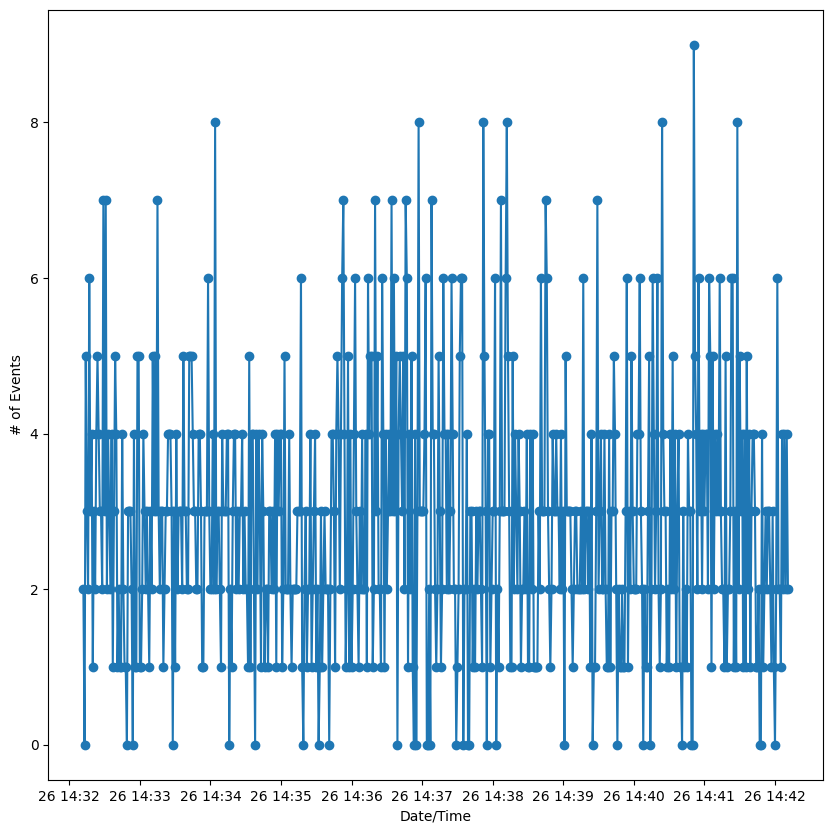

In [15]:
def plot_graph(response):
    plt.figure(figsize=(10,10))
    plt.xlabel('Date/Time')
    plt.ylabel('# of Events')
    plt.plot(response['time'], response['event_count'], marker='o')        
    plt.show()

column_titles = ['time','event_count']
df = pd.DataFrame((result_evt.get_points()),columns=['event_count','time']).dropna()
df_response = df.reindex(columns=column_titles) #Incase time is not first column. Setting time to be first column.
df_response['time'] = pd.to_datetime(df_response['time'], format='%Y-%m-%dT%H:%M:%SZ')
df_response['time'] = df_response['time'].dt.tz_localize('utc').dt.tz_convert('Europe/Paris') #Set to your local time.
plot_graph(df_response)



**WOW** we made a graph just like that! But what does it show?
We have the frequency of cosmic rays arriving over a 10 minute period. 
Can we make it clearer? Let's remove the 'o's and see...

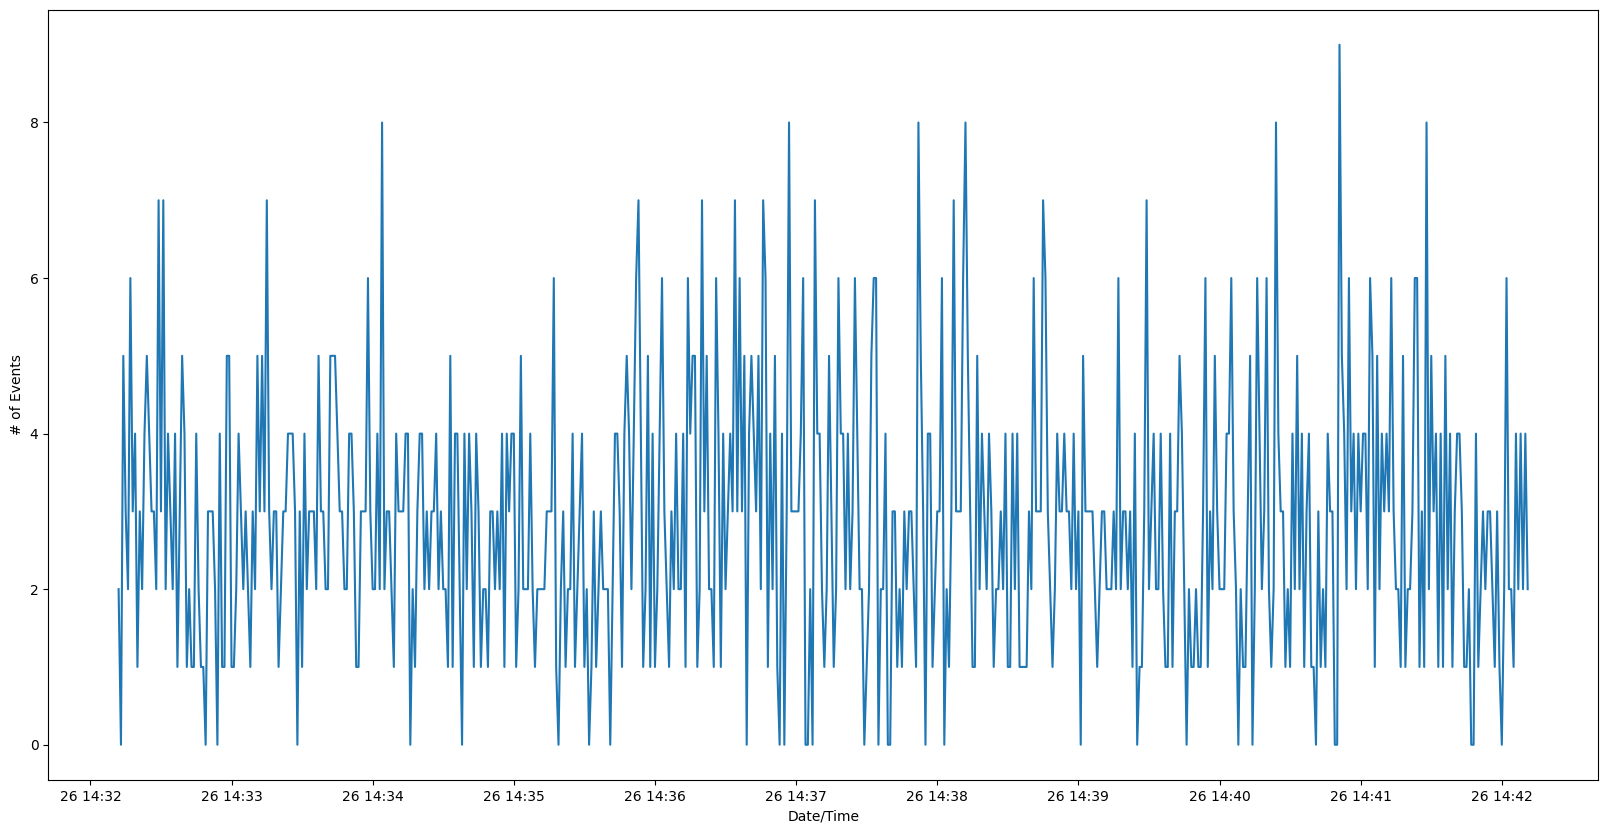

In [16]:
def plot_graph(response):
    plt.figure(figsize=(20,10))
    plt.xlabel('Date/Time')
    plt.ylabel('# of Events')
    plt.plot(response['time'], response['event_count'],)        
    plt.show()

column_titles = ['time','event_count']
df = pd.DataFrame((result_evt.get_points()),columns=['event_count','time']).dropna()
df_response = df.reindex(columns=column_titles) #Incase time is not first column. Setting time to be first column.
df_response['time'] = pd.to_datetime(df_response['time'], format='%Y-%m-%dT%H:%M:%SZ')
df_response['time'] = df_response['time'].dt.tz_localize('utc').dt.tz_convert('Europe/Paris') #Set to your local time.
plot_graph(df_response)



That's better! Here we can see the events every second for 10 minutes. What does it tell us?
They look random, and range from 0 to 9 per second. This is what we would expect.
The arrival time of cosmic rays at our detector is random, since they are generated by a chaotic process.
The rate of cosmic rays arriving at the surface of the earth is constrained (very approximately 1 muon per cm2 per minute).
Our detector has an area of 200cm2, so we expect a mean of about 3.3 muons per second. 
What is the average of this data?

In [17]:
df_response['event_count'].mean()

2.845

Not bad! But why isn't it 3.3?
Again, to make a correct analysis, we need to know about our detector. 
No cosmic ray detector is perfect, there are always small defects which mean that we won't get the ideal response.
How close are we to ideal?

In [18]:
efficiency_of_detector = 2.845/3.3
print(efficiency_of_detector)

0.8621212121212122


**86%**, it isn't perfect, but I would be happy with that result in an exam. 
In practice, we've only looked at 10 minutes of data. We should look at more, but that will take longer and it's time for lunch!

## Post script...
What was the temperature of the detector?

In [19]:
query_temp_big = "SELECT \"Temp\" FROM \"CosmicPiV1.8.1\" GROUP BY * ORDER BY DESC LIMIT 10000"

In [20]:
print("Querying data: " + query_temp_big)
result_temp_big = client.query(query_temp_big)

Querying data: SELECT "Temp" FROM "CosmicPiV1.8.1" GROUP BY * ORDER BY DESC LIMIT 10000


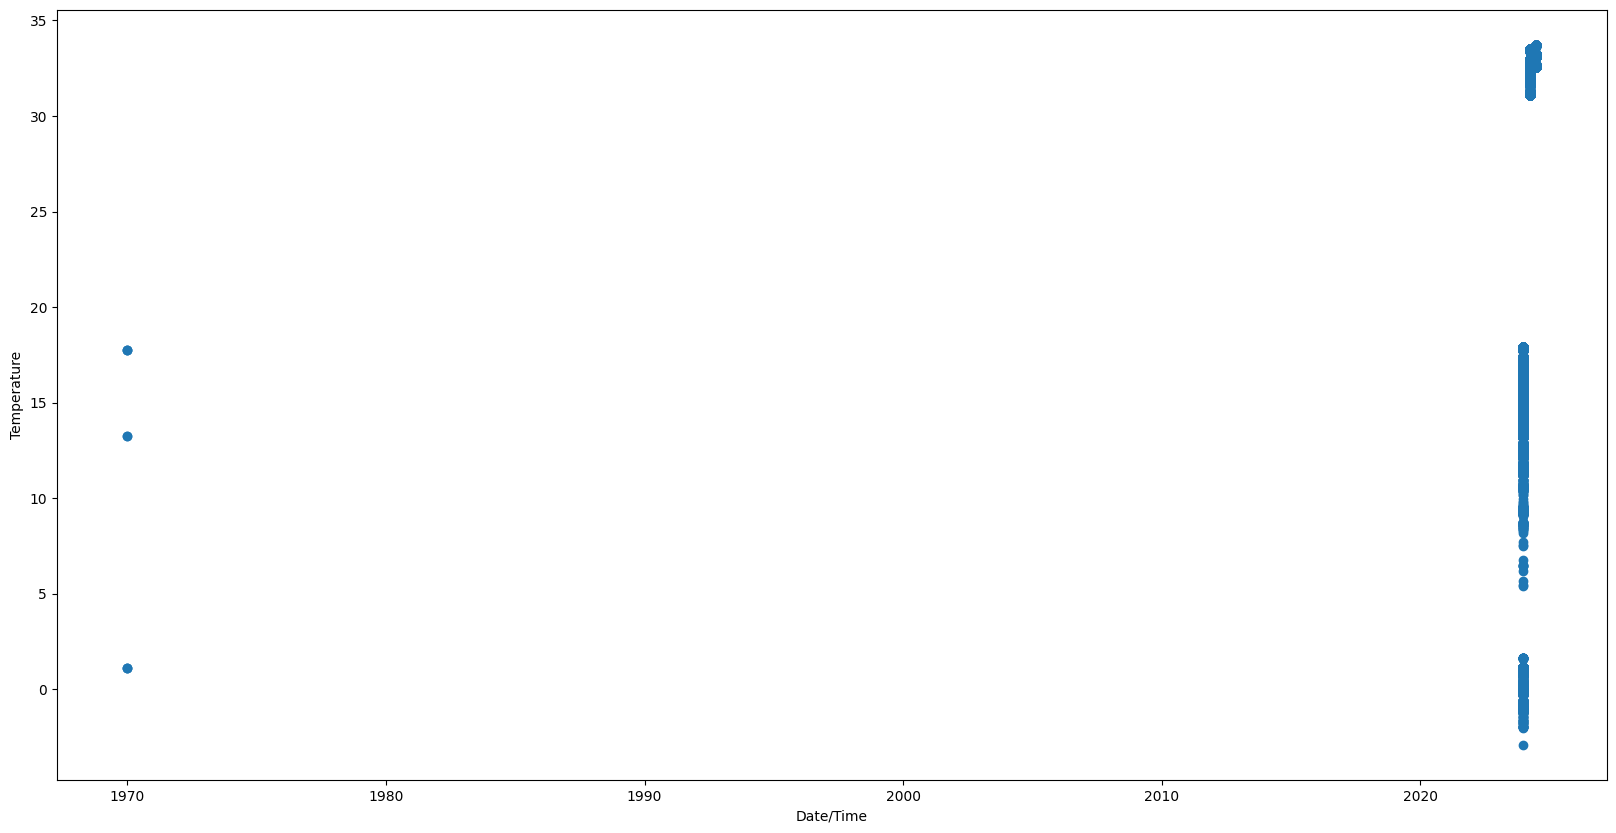

In [21]:
def plot_big_graph(response):
    plt.figure(figsize=(20,10))
    plt.xlabel('Date/Time')
    plt.ylabel('Temperature')
    plt.scatter(response['time'], response['Temp'])        
    plt.show()

column_titles = ['time','Temp']
df = pd.DataFrame((result_temp_big.get_points()),columns=['Temp','time']).dropna()
df_response_big = df.reindex(columns=column_titles) #Incase time is not first column. Setting time to be first column.
df_response_big['time'] = pd.to_datetime(df_response_big['time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df_response_big['time'] = df_response_big['time'].dt.tz_localize('utc').dt.tz_convert('Europe/Paris') #Set to your local time.
plot_big_graph(df_response_big)



Not bad! From below freezing all the way up to about 34C. There are still some data points from 1970 that we need to clean up, but that will need another workshop.